Oslo, Norge
(59.9133301, 10.7389701)
it work


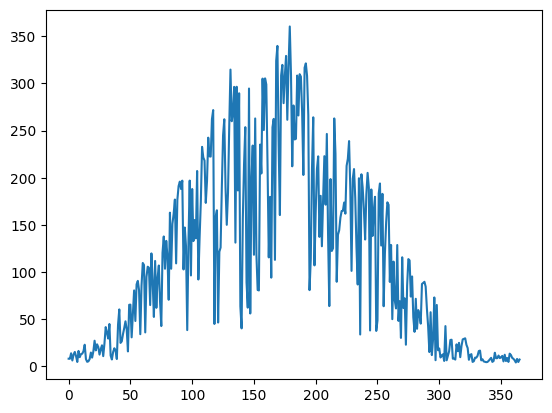

In [36]:
import requests
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="miljøanalyse_abel")

location = geolocator.geocode(input("location: "))
print(location.address)
print((location.latitude, location.longitude))

starttid = "20050101" #YYYYMMDD
sluttid = "20060101" #YYYYMMDD
type = "daily"
lon_min, lon_max = location.longitude - 1.01, location.longitude + 1.01
lat_min, lat_max = location.latitude - 1.01, location.latitude + 1.01

url = f"https://power.larc.nasa.gov/api/temporal/{type}/regional?parameters=ALLSKY_SFC_SW_DWN&community=SB&longitude-min={lon_min}&longitude-max={lon_max}&latitude-min={lat_min}&latitude-max={lat_max}&start={starttid}&end={sluttid}&format=JSON"

response = requests.get(url)
if response.status_code == 422:
    print("it kill itself")
    exit("rip")
elif response.status_code == 200:
    print("it work")
elif response.status_code == 429:
    print("stop spam pls")
    exit("rip")

data = response.json()["features"][0]["properties"]["parameter"]["ALLSKY_SFC_SW_DWN"]

plt.plot(range(0,len(data.values())),data.values())
plt.show()

df = pd.DataFrame(list(data.values()),list(data.keys()))